In [1]:
# Force garbage collection
import gc
gc.collect()

34

In [2]:
import pandas as pd
import geopandas as gpd
import xarray as xr
import pyproj
from tqdm import tqdm
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import roc_curve
from sklearn.metrics import average_precision_score
import warnings
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve, auc

In [3]:
import matplotlib.pyplot as plt

In [4]:
import pickle
# %pip install shap --upgrade
import shap

c:\Users\fangshuye\AppData\Local\anaconda3\envs\py311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
# check python version and all packages version
def check_python_version():
    import sys
    print("Python version")
    print (sys.version)
    print("Pandas version")
    print(pd.__version__)
    print("SHAP version")
    print(shap.__version__)


check_python_version()

Python version
3.11.9 | packaged by Anaconda, Inc. | (main, Apr 19 2024, 16:40:41) [MSC v.1916 64 bit (AMD64)]
Pandas version
2.2.2
SHAP version
0.47.1


In [ ]:
# season_map = {'summer': [5,6,7,8], 
#                   'winter': [10,11,12,1,2,3]}

# wind_direction_range_map = {'north': [315, 90],
#                             'south': [360, 100]}

In [6]:
def data_prep(data, eval_year=2007, area='all', 
              season='all',
              wind_speed_threshold=0, 
              wind_speed_region="not filtered",
              fire_size_threshold=0,
              if_filter_wind_direction=False,
              wind_direction_range=[0, 360],
              month_list=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
              fire_event_only=True):
    # Initialize a list to store log messages
    log_messages = []

    # Log the parameters
    log_messages.append(f"Parameters: eval_year={eval_year}, area={area}, season={season}, "
                        f"wind_speed_threshold={wind_speed_threshold}, wind_speed_region={wind_speed_region}, "
                        f"fire_size_threshold={fire_size_threshold}, if_filter_wind_direction={if_filter_wind_direction}, "
                        f"wind_direction_range={wind_direction_range}, month_list={month_list}, "
                        f"fire_event_only={fire_event_only}")

    # Check if Year column exists, if not, add it
    if 'Year' not in data.columns:
        data['Year'] = data['day'].dt.year
        log_messages.append('Year column is added')

    # Check if Month column exists, if not, add it
    if 'Month' not in data.columns:
        data['Month'] = data['day'].dt.month
        log_messages.append('Month column is added')
    
    month_list = season_map[season] if season in season_map else month_list

    # Filter data to be in month_list
    data = data[data['Month'].isin(month_list)]
    log_messages.append(f"The unique values of month are: {data['Month'].unique()}")

    # add log messages for range of day
    log_messages.append(f"The min and max day are: {data['day'].min()}, {data['day'].max()}")

    if area == "south":
        data = data[data['lat'] < 35.75]
        log_messages.append(f"The min and max lat are: {data['lat'].min()}, {data['lat'].max()}")
    elif area == "north":
        data = data[data['lat'] >= 35.75]
        log_messages.append(f"The min and max lat are: {data['lat'].min()}, {data['lat'].max()}")

    # Filter the data using wind_speed_threshold and wind_speed_region (>= or <)
    if wind_speed_region == ">=":
        data = data[data['wind_speed'] >= wind_speed_threshold]
        log_messages.append(f"The min and max wind speed are: {data['wind_speed'].min()}, {data['wind_speed'].max()}")
    elif wind_speed_region == "<":
        data = data[data['wind_speed'] < wind_speed_threshold]
        log_messages.append(f"The min and max wind speed are: {data['wind_speed'].min()}, {data['wind_speed'].max()}")
    else:
        log_messages.append('The wind speed is not filtered')
    
    if if_filter_wind_direction:
        log_messages.append('The wind direction is filtered')
        wind_direction_min, wind_direction_max = wind_direction_range
        if wind_direction_min < wind_direction_max:
            # Filter the data to be between wind_direction_min and wind_direction_max
            data = data[(data['wind_from_direction'] >= wind_direction_min) & (data['wind_from_direction'] <= wind_direction_max)]
        else: 
            # Filter the data to be between wind_direction_min and 360 or between 0 and wind_direction_max
            data = data[(data['wind_from_direction'] >= wind_direction_min) & (data['wind_from_direction'] <= 360) | 
                        (data['wind_from_direction'] >= 0) & (data['wind_from_direction'] <= wind_direction_max)]

    if fire_size_threshold > 0:
        # Filter the data to be greater than fire_size_threshold
        log_messages.append('The fire size is filtered')
        data = data[data['min_FIRE_SIZE'] > fire_size_threshold]
        log_messages.append(f"The min and max fire size are: {data['min_FIRE_SIZE'].min()}, {data['min_FIRE_SIZE'].max()}")

    if fire_event_only:
        # Filter the data to be fire event only
        log_messages.append('The fire event is filtered')
        data = data[data['IS_FIRE'] == 1]
        
    log_messages.append(f"The shape of data is: {data.shape}")
    log_messages.append(f"The mean of IS_FIRE is: {data['IS_FIRE'].mean()}")
    log_messages.append(f"The count of IS_FIRE is: {data['IS_FIRE'].sum()}")

    # Return the filtered data and the log messages
    return data, "\n".join(log_messages)

In [ ]:
# # plot ROC curve based on colu IS_FIRE, and preditions
# def save_roc_curve(y_true, y_pred, title='ROC Curve', eval_year=2007, output_path = '../Plot/ROC/', show = False):
#     """
#     Plot the ROC curve and calculate AUC.

#     Parameters:
#         y_true (array-like): True binary labels.
#         y_pred (array-like): Target scores, can either be probability estimates of the positive class or confidence values.
#         title (str): Title of the plot.
        

#     Returns:
#         None
#     """
#     fpr, tpr, thresholds = roc_curve(y_true, y_pred)
#     roc_auc = roc_auc_score(y_true, y_pred)

#     plt.figure(figsize=(8, 6))
#     plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
#     plt.plot([0, 1], [0, 1], color='red', linestyle='--')
#     plt.xlim([0.0, 1.0])
#     plt.ylim([0.0, 1.05])
#     plt.xlabel('False Positive Rate')
#     plt.ylabel('True Positive Rate')
#     plt.title(f'{title} ({eval_year})')
#     plt.legend(loc='lower right')
#     plt.grid()
#     if show:
#         plt.show()
#     else:
#         plt.savefig(os.path.join(output_path, f'roc_curve_{eval_year}.png'))
#     plt.close()

In [7]:
def plot_feature_importance(model, output_path = "../Plot/FeatureImportance/", title='Feature Importance', max_num_features=10, show=False, eval_year=2007):
    """
    Plot the feature importance of a trained model and save the plot.

    Parameters:
        model (xgboost.Booster): Trained XGBoost model.
        output_path (str): Path to save the plot (e.g., 'path/to/plot.png').
        title (str): Title of the plot.
        max_num_features (int): Maximum number of features to display in the plot.

    Returns:
        None
    """
    # Get feature importance scores
    importance = model.get_booster().get_score(importance_type='gain')
    
    # Sort features by importance
    sorted_importance = sorted(importance.items(), key=lambda x: x[1], reverse=True)
    
    # Create a DataFrame for plotting
    df_importance = pd.DataFrame(sorted_importance, columns=['Feature', 'Importance'])
    
    # Limit to max_num_features
    df_importance = df_importance.head(max_num_features)
    # from eval_year, get training year,which is eval_year - 6 to eval_year - 1
    training_start_year = eval_year - 6
    training_end_year = eval_year - 1

    # Plotting
    plt.figure(figsize=(10, min(6 + 0.1 * max_num_features, 20)))  # Limits max heigh
    plt.barh(df_importance['Feature'], df_importance['Importance'], color='skyblue')
    plt.xlabel('Importance Score')
    plt.title(f'{title} ({training_start_year}-{training_end_year})')
    plt.grid(axis='x')

    plt.gca().invert_yaxis()

    if show:
        plt.show()
    else:
        # Save the plot to the specified output path
        plt.savefig(os.path.join(output_path, f'{eval_year}_FI.png'), bbox_inches='tight')
        plt.close()

In [ ]:
# def save_positive_shap_beeswarm_plot(shap_values, feature_names, output_path, top_n=10):
#     """
#     Creates and saves a custom SHAP beeswarm plot for positive SHAP values.

#     Parameters:
#         shap_values (shap.Explanation): SHAP values object.
#         feature_names (list): List of feature names corresponding to the SHAP values.
#         output_path (str): Path to save the plot (e.g., 'path/to/plot.png').
#         top_n (int): Number of top features to display in the plot (default is 10).

#     Returns:
#         None
#     """
#     # Convert SHAP values to a DataFrame
#     shap_df = pd.DataFrame(shap_values.values, columns=feature_names)

#     # Filter only positive SHAP values
#     positive_shap_df = shap_df[shap_df > 0]

#     # Compute the mean of positive SHAP values for ranking
#     positive_mean_shap = positive_shap_df.mean().sort_values(ascending=False)

#     # Sort features based on their positive contributions
#     sorted_features = positive_mean_shap.index[:top_n]  # Top N features
#     sorted_positive_shap_values = positive_shap_df[sorted_features]

#     # Reverse the order of the y-axis
#     reversed_features = sorted_features[::-1]  # Reverse the order of the features

#     # Create a custom beeswarm plot
#     plt.figure(figsize=(10, 8))
#     for i, feature in enumerate(reversed_features):
#         plt.scatter(
#             sorted_positive_shap_values[feature],  # SHAP values for the feature
#             [i] * len(sorted_positive_shap_values),  # Align points for each feature
#             alpha=0.5,
#             color="blue",  # Use a single color for simplicity
#         )

#     plt.yticks(range(len(reversed_features)), reversed_features)  # Use reversed order for y-axis labels
#     plt.axvline(0, color="black", linestyle="--", linewidth=1)  # Add a vertical line at 0
#     plt.xlabel("Positive SHAP Value")
#     plt.ylabel("Feature")
#     plt.title("SHAP Beeswarm Plot (SHAP Values > 0)")
#     plt.grid(True)

#     # Save the plot to the specified output path
#     plt.savefig(output_path, bbox_inches='tight')
#     plt.close()  # Close the figure to free up memory

In [9]:
years = range(2007, 2021)


season_map = {'summer': [6,7,8], 
                  'winter': [10,11,12]}

# Calculate the total number of iterations
total_iterations = len(years) * len(['south', 'north']) * 2

big_fire_size = 1
# surpress warnings
warnings.filterwarnings("ignore")

log_messages = []
# log current date and time
log_messages.append(f"Current date and time: {pd.Timestamp.now()}")
# append season map
log_messages.append(f"Season map: {season_map}")

input_path = '../Clean_Data/Model_Data/Evaluation/Features_w_Label_w_pred/water_year_filter_veg_parquet'
feature_importance_plot_pathall = '../Plot/Water_Year_Filter_Veg/FeatureImportance/ALL/'
feature_importance_plot_pathtop = '../Plot/Water_Year_Filter_Veg/FeatureImportance/TOP25/'
shap_plot_path = '../Plot/Water_Year_Filter_Veg/Shap/'

if not os.path.exists(feature_importance_plot_pathall):
    os.makedirs(feature_importance_plot_pathall)
if not os.path.exists(feature_importance_plot_pathtop):
    os.makedirs(feature_importance_plot_pathtop)
if not os.path.exists(shap_plot_path):
    os.makedirs(shap_plot_path)

with tqdm(total=total_iterations, desc="Processing years, areas, and season") as pbar:
    for yr in years:
        # load parquet data
        Eval_data = pd.read_parquet(f'{input_path}/{yr}_predictions.parquet')
        # Eval_data = pd.read_csv(f'../Clean_Data/Model_Data/Evaluation/Features_w_Label_w_pred/water_year/{yr}_predictions.csv')
        # Eval_data['day'] = pd.to_datetime(Eval_data['day'], format='%Y-%m-%d', errors='coerce')

        # save_roc_curve(Eval_data['IS_FIRE'], Eval_data['predictions'], title='ROC Curve', eval_year=yr, output_path = '../Plot/ROC/')

        # Load the model
        with open(f'../Model/6_water_year_completed_filter_veg/predict_{yr}_6yr_model.pkl', 'rb') as f:
            loaded_model = pickle.load(f)
        features = loaded_model.get_booster().feature_names
        explainer = shap.Explainer(loaded_model)

        plot_feature_importance(loaded_model, title='Feature Importance', max_num_features=80, show=False, output_path = feature_importance_plot_pathall, eval_year=yr)
        plot_feature_importance(loaded_model, title='Feature Importance', max_num_features=25, show=False, output_path = feature_importance_plot_pathtop, eval_year=yr)


        for area in ['south', 'north']:
            for season in ['summer', 'winter']:
                # add separate log messages for each iteration
                log_messages.append(f"Processing year: {yr}, area: {area}, season: {season}")
                # Load the data
                Eval_region_season, log = data_prep(Eval_data, eval_year=yr, area=area, season=season, fire_size_threshold = big_fire_size)

                # append the log messages to the main log
                log_messages.append(log)      

                shap_values = explainer(Eval_region_season[features])

                shap_df = pd.DataFrame(shap_values.values, columns=features)
                positive_shap_df = shap_df[shap_df > 0]
                feature_medians = positive_shap_df.median()
                sorted_features = feature_medians.sort_values(ascending=False).index.tolist()
                col2num = {col: i for i, col in enumerate(Eval_region_season[features].columns)}
                order = list(map(col2num.get, sorted_features))

                # Create and save the SHAP beeswarm plot
                plt.figure()  # Create a new figure
                shap.plots.beeswarm(shap_values, max_display=15, order=order, show=False, group_remaining_features =False)
                plt.title(f"SHAP Beeswarm Plot ({yr}, {area}, {season})")
                plt.savefig(f'{shap_plot_path}/SHAP_Beeswarm_{yr}_{area}_{season}_greater_{big_fire_size}.png', bbox_inches='tight')
                plt.close()  # Close the figure to avoid overlapping plots

                gc.collect()  # Force garbage collection to free up memory
                # Update the progress bar after each iteration
                pbar.update(1)

        # clean up the memory
        del Eval_data

Processing years, areas, and season: 100%|██████████| 56/56 [02:06<00:00,  2.25s/it]


In [10]:
# Save the log messages to a log file
with open('../Logs/plot_shap_water_year_filter_veg_log.txt', 'w') as log_file:
    log_file.write('\n'.join(log_messages))

print("Log file saved to '../Logs/plot_shap_water_year_filter_veg_log.txt'")

Log file saved to '../Logs/plot_shap_water_year_filter_veg_log.txt'


In [19]:
season_map = {'summer': [6,7,8], 
                  'winter': [10,11,12]}
data_record = []
years = range(2007, 2021)

# Calculate the total number of iterations
total_iterations = len(years) * len(['south', 'north']) * 2

big_fire_size = 1
# surpress warnings
warnings.filterwarnings("ignore")

with tqdm(total=total_iterations, desc="Processing years, areas, and season") as pbar:
    for yr in years:
        Eval_data = pd.read_csv(f'../Clean_Data/Model_Data/Evaluation/Features_w_Label_w_pred/water_year/{yr}_predictions.csv')
        Eval_data['day'] = pd.to_datetime(Eval_data['day'], format='%Y-%m-%d', errors='coerce')

        # save # of rows of data to data_record
        data_record.append([yr, area, season, Eval_region_season.shape[0]])
        # save_roc_curve(Eval_data['IS_FIRE'], Eval_data['predictions'], title='ROC Curve', eval_year=yr, output_path = '../Plot/ROC/')

        # Load the model
        with open(f'../Model/6_water_year_completed/predict_{yr}_6yr_model.pkl', 'rb') as f:
            loaded_model = pickle.load(f)
        features = loaded_model.get_booster().feature_names
        explainer = shap.Explainer(loaded_model)

        #plot_feature_importance(loaded_model, title='Feature Importance', max_num_features=80, show=False, output_path = "../Plot/Water_Year/FeatureImportance/ALL/", eval_year=yr)
        #plot_feature_importance(loaded_model, title='Feature Importance', max_num_features=25, show=False, output_path = "../Plot/Water_Year/FeatureImportance/TOP25/", eval_year=yr)


        for area in ['south', 'north']:
            for season in ['summer', 'winter']:
                # Load the data
                Eval_region_season, log = data_prep(Eval_data, eval_year=yr, area=area, season=season, fire_size_threshold = big_fire_size)
                # save log
                with open(f'../Logs/Plot_Water_Year_new_season/Log_{yr}_{area}_{season}_greater_{big_fire_size}.txt', 'w') as f:
                    f.write(log)

                shap_values = explainer(Eval_region_season[features])

                shap_df = pd.DataFrame(shap_values.values, columns=features)
                positive_shap_df = shap_df[shap_df > 0]
                feature_medians = positive_shap_df.median()
                sorted_features = feature_medians.sort_values(ascending=False).index.tolist()
                col2num = {col: i for i, col in enumerate(Eval_region_season[features].columns)}
                order = list(map(col2num.get, sorted_features))

                # Create and save the SHAP beeswarm plot
                plt.figure()  # Create a new figure
                shap.plots.beeswarm(shap_values, max_display=15, order=order, show=False, group_remaining_features =False)
                plt.title(f"SHAP Beeswarm Plot ({yr}, {area}, {season})")
                plt.savefig(f'../Plot/Water_Year/Shap/LimitedSeason/SHAP_Beeswarm_{yr}_{area}_{season}_greater_{big_fire_size}.png', bbox_inches='tight')
                plt.close()  # Close the figure to avoid overlapping plots

                # save_positive_shap_beeswarm_plot(shap_values, features, 
                #                                     f'../Plot/Shap/FireSize/Positive_SHAP_Beeswarm_{yr}_{area}_{season}_greater_10.png', top_n=10)

                gc.collect()  # Force garbage collection to free up memory
                # Update the progress bar after each iteration
                pbar.update(1)

Processing years, areas, and season: 100%|██████████| 56/56 [20:58<00:00, 22.47s/it] 


FI

In [11]:
gc.collect()

692163

In [ ]:
# years = range(2007, 2021)

# # Calculate the total number of iterations
# total_iterations = len(years)

# big_fire_size = 1
# # surpress warnings
# warnings.filterwarnings("ignore")

# with tqdm(total=total_iterations, desc="Processing years, areas, and season") as pbar:
#     for yr in years:
#         Eval_data = pd.read_csv(f'../Clean_Data/Model_Data/Evaluation/Features_w_Label_w_pred/{yr}_predictions.csv')

#         # Load the model
#         with open(f'../Model/6_year_completed/predict_{yr}_6yr_model.pkl', 'rb') as f:
#             loaded_model = pickle.load(f)

#         plot_feature_importance(loaded_model, title='Feature Importance', max_num_features=80, show=False, output_path = "../Plot/FeatureImportance/ALL/", eval_year=yr)
#         plot_feature_importance(loaded_model, title='Feature Importance', max_num_features=25, show=False, output_path = "../Plot/FeatureImportance/TOP25/", eval_year=yr)

#         gc.collect()  # Force garbage collection to free up memory
#         # Update the progress bar after each iteration
#         pbar.update(1)

Processing years, areas, and season: 100%|██████████| 14/14 [24:01<00:00, 102.98s/it]


ROC Plots in One

In [12]:
gc.collect()

0

In [13]:
# Setup
fpr_points = np.linspace(0, 1, 100)
recall_points = np.linspace(0, 1, 100)

tprs = []
aucs = []
precisions = []
aps = []

all_y_true = []

years = range(2007, 2021)

input_path = '../Clean_Data/Model_Data/Evaluation/Features_w_Label_w_pred/water_year_filter_veg_parquet'


with tqdm(total=len(years), desc="Processing years, areas, and season") as pbar:
    for yr in years:
        # Eval_data = pd.read_csv(f'../Clean_Data/Model_Data/Evaluation/Features_w_Label_w_pred/water_year/{yr}_predictions.csv')
        # read the parquet file
        Eval_data = pd.read_parquet(f'{input_path}/{yr}_predictions.parquet')
        y_true = Eval_data['IS_FIRE']
        y_score = Eval_data['predictions']

        all_y_true.extend(y_true)

        fpr, tpr, _ = roc_curve(y_true, y_score)
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)

        precision, recall, _ = precision_recall_curve(y_true, y_score)
        ap = average_precision_score(y_true, y_score)
        aps.append(ap)


        # Interpolate TPR at fixed FPR points
        interp_tpr = np.interp(fpr_points, fpr, tpr)
        interp_tpr[0] = 0.0  # ensure start at 0
        tprs.append(interp_tpr)

        # Interpolate precision at fixed recall points
        interp_precision = np.interp(recall_points, recall[::-1], precision[::-1])  # reverse for increasing recall
        precisions.append(interp_precision)

        gc.collect()  # Force garbage collection to free up memory
        pbar.update(1)

# Convert to array for easier math
tprs = np.array(tprs)
mean_tpr = tprs.mean(axis=0)
std_tpr = tprs.std(axis=0)
mean_auc = np.mean(aucs)
std_auc = np.std(aucs)


precisions = np.array(precisions)
mean_precision = precisions.mean(axis=0)
std_precision = precisions.std(axis=0)
mean_ap = np.mean(aps)
std_ap = np.std(aps)

Processing years, areas, and season: 100%|██████████| 14/14 [57:49<00:00, 247.85s/it]  


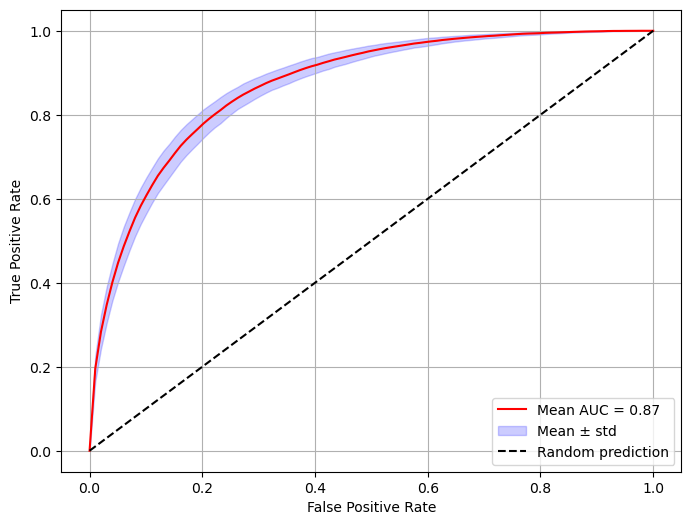

In [14]:
# Plot
save_path = '../Plot/Water_Year_Filter_Veg/ROC'
if not os.path.exists(save_path):
    os.makedirs(save_path)

plt.figure(figsize=(8, 6))

# Mean ROC curve
plt.plot(fpr_points, mean_tpr, color='red', label=f'Mean AUC = {mean_auc:.2f}')

# ±1 std around the mean
plt.fill_between(fpr_points, mean_tpr - std_tpr, mean_tpr + std_tpr, color='blue', alpha=0.2, label='Mean ± std')

# Diagonal line (random prediction)
plt.plot([0, 1], [0, 1], color='black', linestyle='--', label='Random prediction')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('')
plt.legend(loc='lower right')
plt.grid(True)
plt.savefig(f'{save_path}/Mean_ROC_Curve.png', bbox_inches='tight')
plt.show()
plt.close()

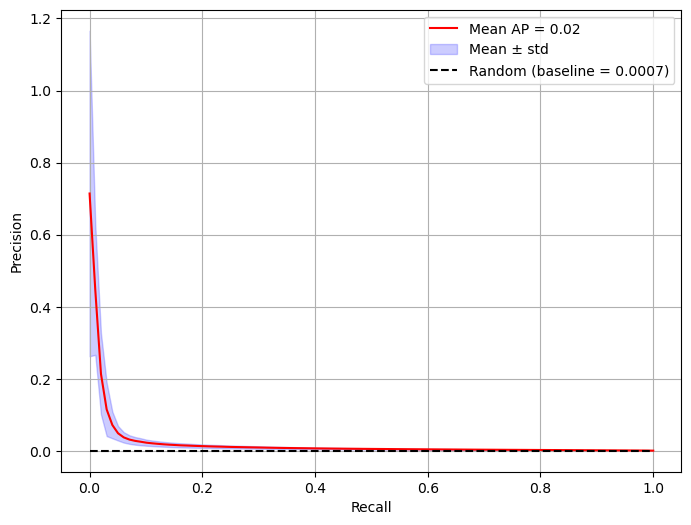

In [15]:
baseline = np.mean(all_y_true)

# Plot
plt.figure(figsize=(8, 6))

# plt.plot(recall_points, mean_precision, color='red', label=f'Mean PR (AP = {mean_ap:.2f} ± {std_ap:.2f})')
plt.plot(recall_points, mean_precision, color='red', label=f'Mean AP = {mean_ap:.2f}')
plt.fill_between(recall_points, mean_precision - std_precision, mean_precision + std_precision, color='blue', alpha=0.2, label='Mean ± std')
plt.hlines(y=baseline, xmin=0, xmax=1, color='black', linestyle='--', label=f'Random (baseline = {baseline:.4f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('')
plt.legend(loc='upper right')
plt.grid(True)
plt.savefig(f'{save_path}/Mean_PR_Curve.png', bbox_inches='tight')
plt.show()
plt.close()

Case Check

Processing years, areas, and season:   0%|          | 0/1 [00:00<?, ?it/s]

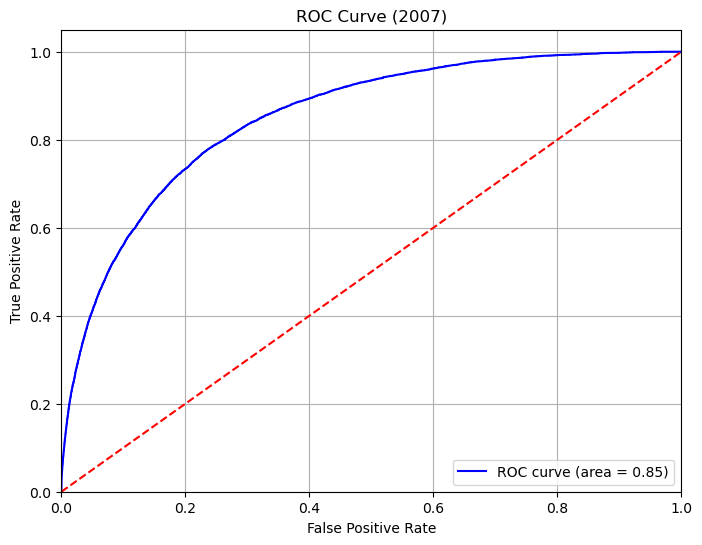

Processing years, areas, and season:   0%|          | 0/1 [01:13<?, ?it/s]


In [11]:
# shap plot
years = [2007]

big_fire_size = 1
# surpress warnings
warnings.filterwarnings("ignore")

with tqdm(total=1, desc="Processing years, areas, and season") as pbar:
    for yr in years:
        Eval_data = pd.read_csv(f'../Clean_Data/Model_Data/Evaluation/Features_w_Label_w_pred/{yr}_predictions.csv')
        Eval_data['day'] = pd.to_datetime(Eval_data['day'], format='%Y-%m-%d', errors='coerce')

        save_roc_curve(Eval_data['IS_FIRE'], Eval_data['predictions'], title='ROC Curve', eval_year=yr, show=True)

Processing years, areas, and season:   0%|          | 0/1 [00:00<?, ?it/s]

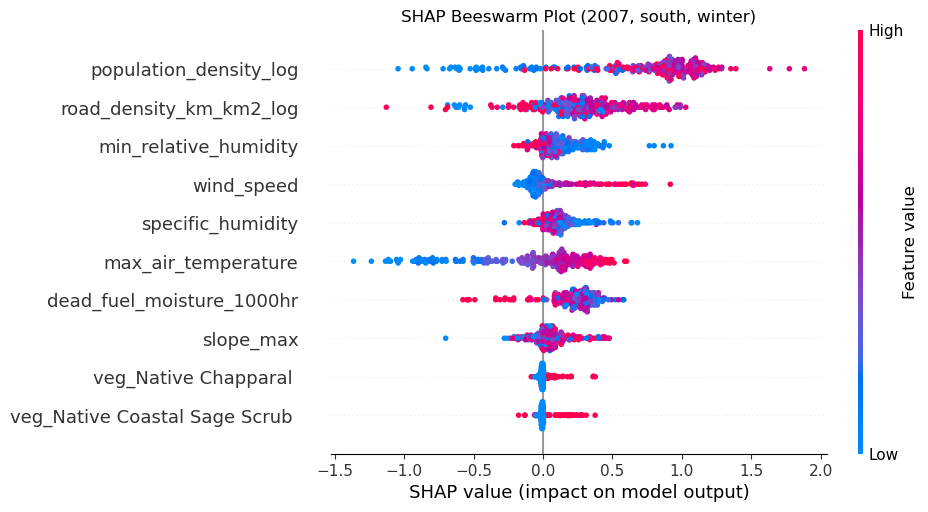

Processing years, areas, and season:   0%|          | 0/1 [01:13<?, ?it/s]


In [ ]:
# shap plot
years = [2007]

big_fire_size = 1
# surpress warnings
warnings.filterwarnings("ignore")

with tqdm(total=1, desc="Processing years, areas, and season") as pbar:
    for yr in years:
        Eval_data = pd.read_csv(f'../Clean_Data/Model_Data/Evaluation/Features_w_Label_w_pred/{yr}_predictions.csv')
        Eval_data['day'] = pd.to_datetime(Eval_data['day'], format='%Y-%m-%d', errors='coerce')

        # Load the model
        with open(f'../Model/6_year_completed/predict_{yr}_6yr_model.pkl', 'rb') as f:
            loaded_model = pickle.load(f)
        features = loaded_model.get_booster().feature_names
        explainer = shap.Explainer(loaded_model)

        for area in ['south']:
            for season in ['winter']:
                # Load the data
                Eval_region_season, log = data_prep(Eval_data, eval_year=yr, area=area, season=season, fire_size_threshold = big_fire_size)
                shap_values = explainer(Eval_region_season[features])

                # Create and save the SHAP beeswarm plot
                plt.figure()  # Create a new figure
                shap.plots.beeswarm(shap_values, max_display=10, order=shap_values.max(0), show=False, group_remaining_features =False)
                plt.title(f"SHAP Beeswarm Plot ({yr}, {area}, {season})")
                #plt.savefig(f'../Plot/Shap/FireSize/greater1_log/SHAP_Beeswarm_{yr}_{area}_{season}_greater_{big_fire_size}.png', bbox_inches='tight')
                plt.show()

In [57]:
years = [2012]

big_fire_size = 1
# surpress warnings
warnings.filterwarnings("ignore")

with tqdm(total=1, desc="Processing years, areas, and season") as pbar:
    for yr in years:
        Eval_data = pd.read_csv(f'../Clean_Data/Model_Data/Evaluation/Features_w_Label_w_pred/{yr}_predictions.csv')
        Eval_data['day'] = pd.to_datetime(Eval_data['day'], format='%Y-%m-%d', errors='coerce')

        # Load the model
        with open(f'../Model/6_year_completed/predict_{yr}_6yr_model.pkl', 'rb') as f:
            loaded_model = pickle.load(f)
        features = loaded_model.get_booster().feature_names
        explainer = shap.Explainer(loaded_model)

        for area in ['south']:
            for season in ['winter']:
                # Load the data
                Eval_region_season, log = data_prep(Eval_data, eval_year=yr, area=area, season=season, fire_size_threshold = big_fire_size)
                shap_values = explainer(Eval_region_season[features])

                # Create and save the SHAP beeswarm plot
                plt.figure()  # Create a new figure
                shap.plots.beeswarm(shap_values, max_display=10, order=shap_values.median(0), show=False, group_remaining_features =False)
                plt.title(f"SHAP Beeswarm Plot ({yr}, {area}, {season})")
                #plt.savefig(f'../Plot/Shap/FireSize/greater1_log/SHAP_Beeswarm_{yr}_{area}_{season}_greater_{big_fire_size}.png', bbox_inches='tight')
                plt.show()

Processing years, areas, and season:   0%|          | 0/1 [00:46<?, ?it/s]


AttributeError: 'Explanation' object has no attribute 'median'

<Figure size 640x480 with 0 Axes>

In [ ]:
shap_values.shape # (data_points, features)

(42, 41)

In [38]:
shap_df = pd.DataFrame(shap_values.values, columns=features)


In [40]:
shap_df.head()

,dead_fuel_moisture_1000hr,dead_fuel_moisture_100hr,max_air_temperature,max_relative_humidity,min_air_temperature,min_relative_humidity,precipitation_amount,specific_humidity,surface_downwelling_shortwave_flux_in_air,wind_speed,...,veg_Native Grassland,veg_Native Inland Scrub,veg_Native Oak Woodland,veg_Native Wetland,veg_Non-native forest,veg_Non-native grassland,veg_Non-native shrub,veg_Riparian,veg_Urban,veg_Water
0,-0.288329,0.098667,-0.049729,0.006072,-0.059954,0.052269,0.013830,0.120641,-0.108409,-0.027066,...,0.002734,-0.005824,0.000808,7.802925e-05,-0.005617,0.011813,-0.001976,-0.005935,0.008542,0.000026
1,0.007604,0.026142,-0.281549,-0.021413,-0.073091,0.041353,0.010672,-0.028559,-0.134260,-0.024929,...,-0.369291,-0.005197,0.000257,-4.507119e-07,-0.006660,0.010253,-0.000533,-0.003306,-0.004798,-0.000091
2,0.356253,0.299747,-0.840548,0.087701,-0.053996,0.114444,0.002885,0.265744,-0.004300,0.252551,...,0.016937,0.000854,0.000837,-5.838977e-05,-0.002615,-0.090168,-0.000796,-0.007606,-0.014978,0.000037
3,-0.296531,0.078070,0.145669,-0.007231,-0.038420,0.091762,-0.000330,0.175361,-0.264135,0.271413,...,0.007391,-0.009825,0.000247,2.436674e-06,-0.043126,-0.005496,-0.005025,0.095927,-0.004144,-0.000483
4,0.263950,0.018432,0.129184,0.030026,-0.061131,0.188570,0.003072,0.170368,-0.154371,-0.072268,...,0.007183,-0.011160,0.000281,2.436674e-06,0.000813,-0.011351,-0.001696,-0.006459,0.022580,-0.000178


In [42]:
positive_shap_df

,dead_fuel_moisture_1000hr,dead_fuel_moisture_100hr,max_air_temperature,max_relative_humidity,min_air_temperature,min_relative_humidity,precipitation_amount,specific_humidity,surface_downwelling_shortwave_flux_in_air,wind_speed,...,veg_Native Grassland,veg_Native Inland Scrub,veg_Native Oak Woodland,veg_Native Wetland,veg_Non-native forest,veg_Non-native grassland,veg_Non-native shrub,veg_Riparian,veg_Urban,veg_Water
0,NaN,0.098667,NaN,0.006072,NaN,0.052269,0.013830,0.120641,NaN,NaN,...,0.002734,NaN,0.000808,7.802925e-05,NaN,0.011813,NaN,NaN,0.008542,0.000026
1,0.007604,0.026142,NaN,NaN,NaN,0.041353,0.010672,NaN,NaN,NaN,...,NaN,NaN,0.000257,NaN,NaN,0.010253,NaN,NaN,NaN,NaN
2,0.356253,0.299747,NaN,0.087701,NaN,0.114444,0.002885,0.265744,NaN,0.252551,...,0.016937,0.000854,0.000837,NaN,NaN,NaN,NaN,NaN,NaN,0.000037
3,NaN,0.078070,0.145669,NaN,NaN,0.091762,NaN,0.175361,NaN,0.271413,...,0.007391,NaN,0.000247,2.436674e-06,NaN,NaN,NaN,0.095927,NaN,NaN
4,0.263950,0.018432,0.129184,0.030026,NaN,0.188570,0.003072,0.170368,NaN,NaN,...,0.007183,NaN,0.000281,2.436674e-06,0.000813,NaN,NaN,NaN,0.022580,NaN
5,0.336060,0.012810,NaN,0.114081,0.025617,NaN,0.021366,NaN,NaN,NaN,...,0.005573,NaN,NaN,NaN,0.004464,0.005407,NaN,NaN,0.001058,NaN
6,0.022574,0.076656,0.244713,0.004840,NaN,0.046029,0.004562,0.066310,NaN,NaN,...,0.010708,0.000893,NaN,NaN,0.001887,0.005925,NaN,NaN,NaN,NaN
7,0.325843,0.074220,0.147737,0.027076,0.009523,0.399078,0.000077,0.124297,NaN,NaN,...,0.011535,NaN,NaN,3.245941e-05,NaN,0.002235,NaN,NaN,NaN,NaN
8,0.317161,0.080168,NaN,0.021936,0.007357,0.047520,0.005212,0.044982,NaN,NaN,...,0.013755,NaN,0.000011,NaN,NaN,0.002741,NaN,NaN,NaN,0.000043
9,0.289668,0.007676,0.163773,NaN,0.009120,0.146749,0.003885,0.064090,NaN,NaN,...,0.006603,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.004176,NaN


In [51]:
shap_values = explainer(Eval_region_season[features])
shap_df = pd.DataFrame(shap_values.values, columns=features)

In [52]:
idex = shap_df[shap_df['veg_Water '] > 0]

In [53]:
idex

,dead_fuel_moisture_1000hr,dead_fuel_moisture_100hr,max_air_temperature,max_relative_humidity,min_air_temperature,min_relative_humidity,precipitation_amount,specific_humidity,surface_downwelling_shortwave_flux_in_air,wind_speed,...,veg_Native Grassland,veg_Native Inland Scrub,veg_Native Oak Woodland,veg_Native Wetland,veg_Non-native forest,veg_Non-native grassland,veg_Non-native shrub,veg_Riparian,veg_Urban,veg_Water
0,-0.288329,0.098667,-0.049729,0.006072,-0.059954,0.052269,0.013830,0.120641,-0.108409,-0.027066,...,0.002734,-0.005824,0.000808,7.802925e-05,-0.005617,0.011813,-0.001976,-0.005935,0.008542,0.000026
2,0.356253,0.299747,-0.840548,0.087701,-0.053996,0.114444,0.002885,0.265744,-0.004300,0.252551,...,0.016937,0.000854,0.000837,-5.838977e-05,-0.002615,-0.090168,-0.000796,-0.007606,-0.014978,0.000037
8,0.317161,0.080168,-0.028630,0.021936,0.007357,0.047520,0.005212,0.044982,-0.182551,-0.017529,...,0.013755,-0.009106,0.000011,-1.876847e-05,-0.005985,0.002741,-0.001927,-0.008389,-0.002464,0.000043
11,0.223104,0.119588,0.376954,-0.006731,0.061608,0.042903,0.001720,0.139113,-0.189392,-0.017782,...,0.012727,-0.002974,0.000925,3.640434e-05,-0.005706,-0.000201,-0.002003,-0.006813,-0.005123,0.300242
31,-0.320225,-0.260903,-0.664354,-0.047171,-0.033958,-0.095755,0.019193,0.000897,-0.141325,-0.113743,...,0.008595,-0.008664,-0.000295,-4.629937e-07,0.000385,0.014462,-0.002199,-0.019046,0.012276,0.000035


In [54]:
Eval_region_season['veg_Water '].value_counts()

veg_Water 
False    41
True      1
Name: count, dtype: int64

In [55]:
Eval_region_season.iloc[11]

lon                                                  -117.641667
lat                                                         33.9
day                                          2009-11-03 00:00:00
dead_fuel_moisture_1000hr                               9.400001
dead_fuel_moisture_100hr                                     5.5
pdsi_pre_interpolated                                      -2.41
pdsi_class                                                   3.0
max_air_temperature                                        306.6
max_relative_humidity                                       38.5
max_wind_speed                                               2.5
min_air_temperature                                        286.1
min_relative_humidity                                        9.5
precipitation_amount                                         0.0
specific_humidity                                         0.0037
surface_downwelling_shortwave_flux_in_air                  180.5
wind_from_direction      

In [56]:
shap_df.loc[11]

dead_fuel_moisture_1000hr                    0.223104
dead_fuel_moisture_100hr                     0.119588
max_air_temperature                          0.376954
max_relative_humidity                       -0.006731
min_air_temperature                          0.061608
min_relative_humidity                        0.042903
precipitation_amount                         0.001720
specific_humidity                            0.139113
surface_downwelling_shortwave_flux_in_air   -0.189392
wind_speed                                  -0.017782
SWE                                          0.012126
population_density_log                      -0.387772
LAI                                         -0.004477
pdsi                                        -0.098157
slope_max                                   -0.018577
road_density_km_km2_log                      0.635246
wind_direction_category_N                    0.002236
wind_direction_category_NE                  -0.020391
wind_direction_category_E   

In [34]:
shap_df['veg_Water '].value_counts()

veg_Water 
-0.000377    27
-0.000378    10
-0.000367     7
-0.000372     5
-0.000310     4
-0.000385     2
-0.000404     2
-0.000180     2
-0.000188     2
-0.000317     2
-0.000354     2
-0.000178     2
-0.000639     2
-0.000298     1
-0.000343     1
-0.000317     1
-0.000363     1
-0.000320     1
-0.000393     1
-0.000122     1
-0.000411     1
-0.000373     1
-0.000094     1
-0.000188     1
-0.000190     1
-0.000388     1
-0.000371     1
 0.000000     1
-0.000365     1
-0.000370     1
-0.000321     1
-0.000389     1
-0.000400     1
-0.000348     1
-0.000182     1
-0.000096     1
-0.000350     1
-0.000393     1
-0.000199     1
-0.000353     1
-0.000383     1
-0.000352     1
-0.000324     1
Name: count, dtype: int64